# RNA-seq expression - Analysis

## Aims
* Run this protocol and solve any issues associated with it
* Understand different quantification of rna sequences
* Learn what is `stranded` and read some articles about it

## To do
* Read articles and watch videos of quantification of rna-seq
* Videos [listed on this page](https://www.youtube.com/playlist?list=PLeB-Dlq-v6tY3QLdQBA7rwb4a7fK9mLpv)
* Articles includes [Signal et al (2022)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-022-04572-7) and [Definition of stranded](https://rnabio.org/module-09-appendix/0009/12/01/StrandSettings/).

## Overview

> ../../images/rna_quantification.jpeg (495.9 KiB):

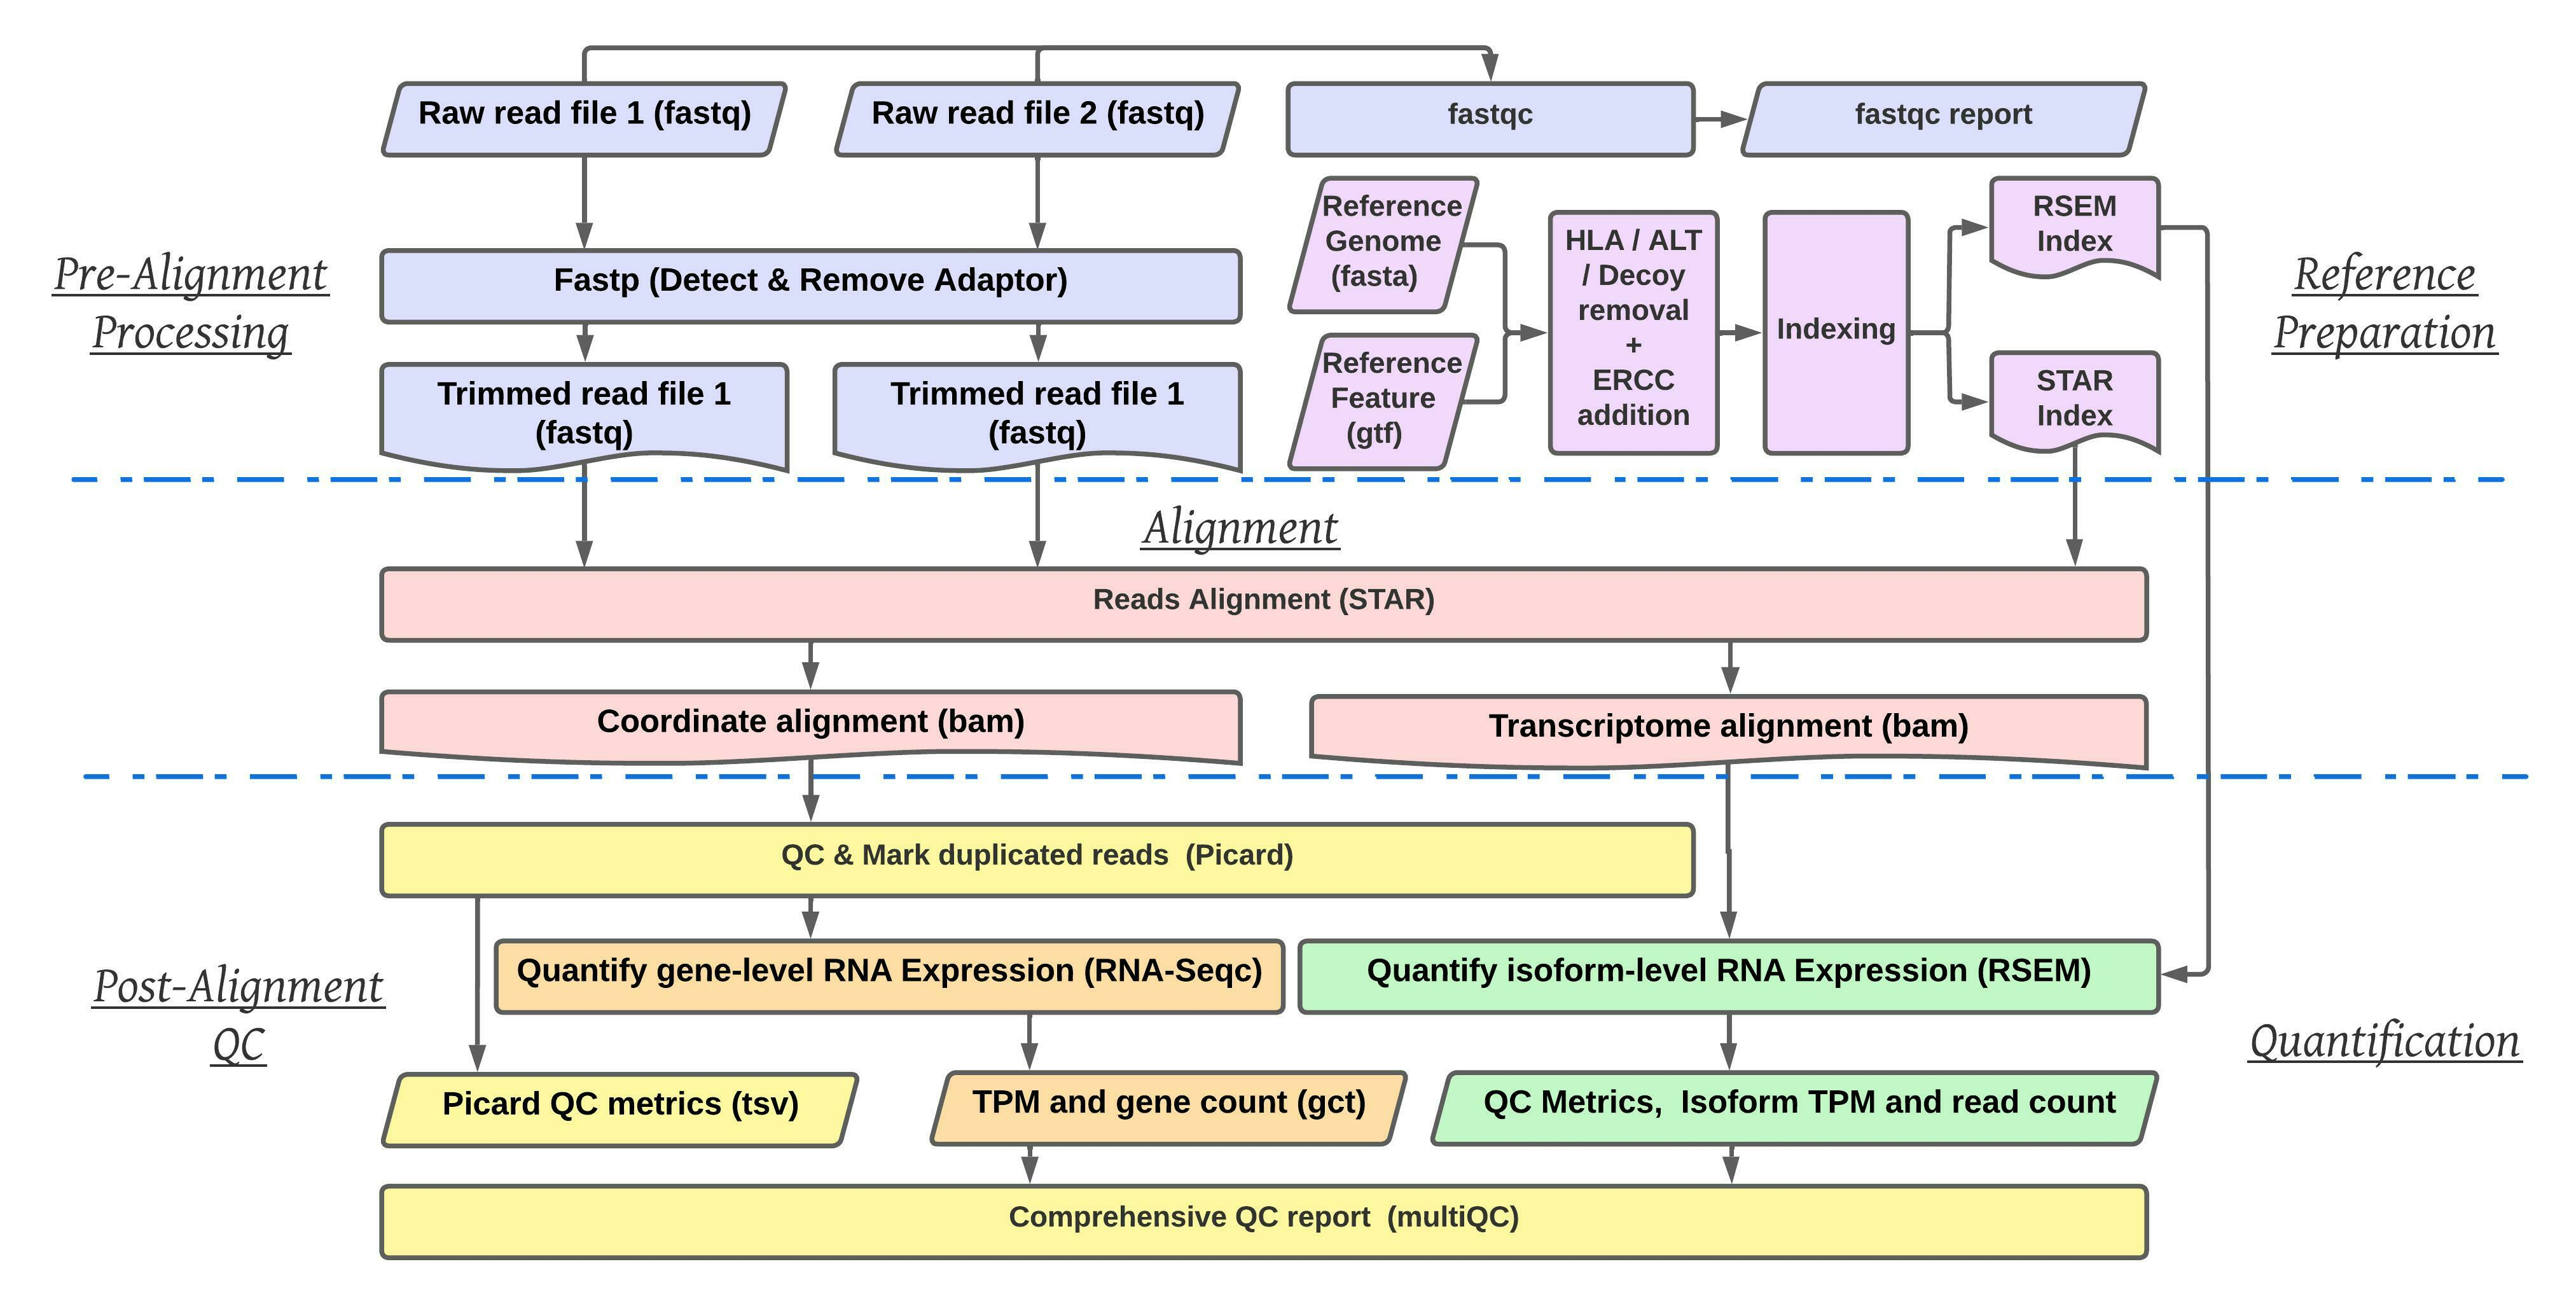

In [2]:
%preview ../../images/rna_quantification.jpeg

* Quality control 
* Expression level quantification
- Gene-level quantifications
    - Read counts and TPM values were produced with RNA-SeQC v2.4.2 (DeLuca et al., Bioinformatics, 2012 ), using the some read-level filters.
- Exon-level quantifications
    - For exon-level read counts, if a read overlapped multiple exons, then a fractional value equal to the portion of the read contained within that exon was allotted. Transcript-level quantifications were calculated using RSEM v1.3.0.
* Normalization 
* `strand` option
- Some steps requires you specify strand option via `--strand`

## Input
* Reference data produced in reference_data protocol
* Collection of fastq file and a sample list file(49 samples), can be downloaded using `synapse get -r syn36422377`.

## Details

### Perform data quality summary via fastqc

In [ ]:
sos run /home/ziningqi0913/xqtl-pipeline/pipeline/RNA_calling.ipynb fastqc \
    --cwd /home/ziningqi0913/output/rnaseq/fastqc \
    --samples /home/ziningqi0913/fastq/xqtl_protocol_data.fastqlist \
    --data-dir /home/ziningqi0913/fastq \
    --container /home/ziningqi0913/containers/rna_quantification.sif \
    --gtf /home/ziningqi0913/reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.ERCC.gtf


### Read alignment via STAR and QC via Picard

In [ ]:
sos run pipeline/RNA_calling.ipynb STAR_output \
    --cwd output/rnaseq --samples ROSMAP_data/RNASeq/fastq/xqtl_protocol_data.fastqlist \
    --data-dir ROSMAP_data/RNASeq/fastq --STAR-index reference_data/STAR_Index/ \
    --gtf reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.ERCC.gtf \
    --container containers/rna_quantification.sif \
    --reference-fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta \
    --ref-flat reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.ERCC.ref.flat

This step requires 40G of memory, which can't be processed by VM. So I skipped this step and downloaded intermediate files to do further processing. To figure out what files will be used in next steps, download the file shown in next steps which I don't have, then download files listed in that file.

### Call gene-level RNA expression via rnaseqc
Following steps generate the count table of gene expression

In [ ]:
sos run /home/ziningqi0913/xqtl-pipeline/pipeline/RNA_calling.ipynb rnaseqc_call \
    --cwd /home/ziningqi0913/output/rnaseq \
    --samples /home/ziningqi0913/fastq/xqtl_protocol_data.fastqlist    --data-dir /home/ziningqi0913/fastq \
    --gtf /home/ziningqi0913/reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.gtf \
    --container /home/ziningqi0913/containers/rna_quantification.sif \
    --reference-fasta /home/ziningqi0913/reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy.fasta \
    --bam_list /home/ziningqi0913/output/rnaseq/xqtl_protocol_data_bam_list

### Call transcript level RNA expression via RSEM

In [ ]:
sos run /home/ziningqi0913/xqtl-pipeline/pipeline/RNA_calling.ipynb rsem_call  \
    --cwd /home/ziningqi0913/output/rnaseq   \
    --samples /home/ziningqi0913/fastq/xqtl_protocol_data.fastqlist  \
    --data-dir /home/ziningqi0913/fastq/   \
    --RSEM-index /home/ziningqi0913/reference_data/RSEM_Index/   \
    --container /home/ziningqi0913/containers/rna_quantification.sif   \
    --bam_list /home/ziningqi0913/output/rnaseq/xqtl_protocol_data_bam_list   

### Multi-sample RNA-seq QC

In [ ]:
sos run /home/ziningqi0913/xqtl-pipeline/pipeline/bulk_expression_QC.ipynb qc \
    --cwd /home/ziningqi0913/output/rnaseq \ \
    --tpm-gct /home/ziningqi0913/output/rnaseq/xqtl_protocol_data.rnaseqc.gene_tpm.gct.gz \
    --counts-gct /home/ziningqi0913/output/rnaseq/xqtl_protocol_data.rnaseqc.gene_readsCount.gct.gz \
    --container /home/ziningqi0913/containers/rna_quantification.sif 

### Multi-sample read count normalization

In [ ]:
sos run /home/ziningqi0913/xqtl-pipeline/pipeline/bulk_expression_normalization.ipynb normalize \
    --cwd /home/ziningqi0913/output/rnaseq \
    --tpm-gct /home/ziningqi0913/output/rnaseq/xqtl_protocol_data.rnaseqc.low_expression_filtered.outlier_removed.tpm.gct.gz \
    --counts-gct /home/ziningqi0913/output/rnaseq/xqtl_protocol_data.rnaseqc.low_expression_filtered.outlier_removed.geneCount.gct.gz \
    --annotation-gtf /home/ziningqi0913/reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.ERCC.gtf  \
    --container /home/ziningqi0913/containers/rna_quantification.sif \
    --count-threshold 1 --sample_participant_lookup /home/ziningqi0913/reference_data/sample_participant_lookup.rnaseq

## Output - Screenshots of output shown in Output folder
* After perform data quality summary via fastqc, two `html` file for QC report
* After reading alignment via STAR and QC via Picard, two kinds of bam file:
    - bam file output `sample_id.Aligned.sortedByCoord.bam`
    - bam file output `sample_id.Aligned.toTranscriptome.bam`
* After calling gene-level RNA expression via rnaseqc, a collection of metrics file for each of the samples
* After calling transcript level RNA expression via RSEM, a RSEM_stat folder 
* After final step,
    - TPM count for gene level RNA expression via `rnaseqc`, and isoform level RNA expression via `RSEM`.
    - A bed.gz file that are TensorQTL ready.